In [25]:
#import the necessary libraries
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy as sc
import scipy.spatial.distance as scd

pd.set_option("display.max_rows", 16)
LARGE_FIGSIZE = (12, 8)

In [26]:
#reading the data from file into program
file_name = "cho.txt"
input_df = pd.read_table(file_name,header=None)
#setting the index and renaming column
input_df.rename(columns={input_df.columns[0]:'gene_id'}, inplace=True)
input_df.rename(columns={input_df.columns[1]:'gnd_truth_cluster'}, inplace=True)
input_df = input_df.set_index(input_df.columns[0])

In [27]:
# creating a copy of the input data for data processing
gdf = input_df.copy()
gdf.drop('gnd_truth_cluster', axis=1, inplace=True)

# creating lists of index and columns for reference
gene_exp_column_list = list(gdf.columns)
gene_id_list = list(gdf.index)

# creating a dataframe for storing the largest/latest cluster that each gene belongs to
#gene_2_cluster_mapping = pd.DataFrame(np.nan, index=gene_id_list, columns=['cluster_name'])
cluster_grouping_df = pd.DataFrame(np.nan, index=gene_id_list, columns=['cluster_name'])
columns = ['cluster_name', 'distance']
cluster_dist_df=pd.DataFrame(data=np.zeros((0,len(columns))), columns=columns)
cluster_dist_list_tuples = list()
cluster_grouping_dict = {}     
# creating a dataframe for storing the largest/latest cluster that each gene belongs to
#subset_gene_2_cluster_mapping = pd.DataFrame(np.nan, index=subset_row_idx, columns=['cluster_name'])
gene_2_cluster_mapping = pd.DataFrame(np.nan, index=gene_id_list, columns=['cluster_name'])
cluster_name = "Cluster_"
## initialize all the index values(gene_ids) as clusters
#cluster_dict = {}

In [28]:
def initialize_clusters_subset(cluster_dict_name, cluster_name_starting_with,gene_cluster_dataframe,gdf,
                               row_idx_list):
    # zero_entry_gene --> reference gene with attributes as zero
    zero_entry_gene = np.zeros(shape=(1, len(gene_exp_column_list)), dtype=int)
    for i in range(0, len(row_idx_list)):
        name = cluster_name_starting_with + str(i)
        dist_gene_zero = scd.euclidean(gdf.loc[gdf.index[i], :], zero_entry_gene)
        cluster_dict_name[name] = name
        idx = gene_cluster_dataframe.index[i]
        gene_cluster_dataframe.loc[idx,'cluster_name'] = name
        cluster_dist_list_tuples.append((name,dist_gene_zero))
        #cluster_dist_dataframe = cluster_dist_dataframe.append({'cluster_name':name, 'distance':dist_gene_zero},ignore_index=True)

In [29]:
#gene_2_cluster_mapping

In [30]:
initialize_clusters_subset(cluster_dict_name=cluster_grouping_dict,cluster_name_starting_with=cluster_name,
                           gene_cluster_dataframe=gene_2_cluster_mapping,gdf=gdf,row_idx_list=gene_id_list)
lm_arr = []
# instead of dataframe for distance matrix .. using numpy array
gene_dist_np = np.zeros(shape=(len(gene_id_list), len(gene_id_list)), dtype=float)
# initializing the elements of the np array to nan
gene_dist_np.fill(np.nan)
#cluster_dist_list_tuples
#gene_2_cluster_mapping

In [31]:
def get_min_set_dist_matrix(gdf,idx_list,distance_array):
    for i in range(0, len(idx_list)):
        for j in range(i, len(idx_list)):
            if (not (i == j)):
                distance_array[i, j] = scd.euclidean(gdf.iloc[i, :], gdf.iloc[j, :])

In [32]:
get_min_set_dist_matrix(gdf=gdf,idx_list=gene_id_list,distance_array=gene_dist_np)
#pd.DataFrame(gene_dist_np)

In [33]:
def cluster_of_clusters(distance_array,cluster_dictionary,linkage_matrix,subset_gene_2_cluster_mapping,subset_gdf):
    (row_idx, col_idx) = np.unravel_index(np.nanargmin(distance_array), distance_array.shape)
    cluster_components = [subset_gene_2_cluster_mapping.iloc[row_idx,0],subset_gene_2_cluster_mapping.iloc[col_idx,0]]
    if(len(cluster_components)==0):
        print(row_idx)
        print(col_idx)
    min_dist = distance_array[row_idx, col_idx]
    cluster_name = "Cluster_" + str(len(cluster_dictionary))
    cluster_dictionary[cluster_name] = cluster_components
    # get list of genes belonging to clusters being merged
    list_left = subset_gene_2_cluster_mapping[subset_gene_2_cluster_mapping.cluster_name == cluster_components[0]].index.tolist()
    list_right = subset_gene_2_cluster_mapping[subset_gene_2_cluster_mapping.cluster_name == cluster_components[1]].index.tolist()
    #update cluster name in the mapping df
    subset_gene_2_cluster_mapping[subset_gene_2_cluster_mapping['cluster_name']==cluster_components[0]]=cluster_name
    subset_gene_2_cluster_mapping[subset_gene_2_cluster_mapping['cluster_name']==cluster_components[1]]=cluster_name
    #num_elements 
    num_elements = subset_gene_2_cluster_mapping.cluster_name[subset_gene_2_cluster_mapping.cluster_name==cluster_name].count()
    #cluster_dist_dataframe = cluster_dist_dataframe.append({'cluster_name':cluster_name, 'distance':min_dist},ignore_index=True)
    cluster_dist_list_tuples.append((cluster_name,min_dist))
    linkage_matrix.append([float(cluster_components[0][8:]), float(cluster_components[1][8:]), min_dist,num_elements])
    for i in range(0, len(list_left)):
        idx_left = subset_gdf.index.get_loc(list_left[i])
        for j in range(0, len(list_right)):
            idx_right = subset_gdf.index.get_loc(list_right[j])
            distance_array[idx_left, idx_right] = np.nan
            distance_array[idx_right, idx_left] = np.nan

In [34]:
while(len(gene_2_cluster_mapping['cluster_name'].unique()) > 1):
    cluster_of_clusters(distance_array=gene_dist_np,cluster_dictionary=cluster_grouping_dict,linkage_matrix=lm_arr,subset_gene_2_cluster_mapping=gene_2_cluster_mapping,subset_gdf=gdf)

In [35]:
cluster_dist_df = pd.DataFrame.from_records(cluster_dist_list_tuples)
cluster_dist_df = cluster_dist_df.set_index(cluster_dist_df.columns[0])
cluster_dist_df.index.rename('cluster_name',inplace=True)
cluster_dist_df.rename(columns={1:'distance'}, inplace=True)
#lm_arr[-20:]

In [36]:
import copy
#cluster_grouping_dict_safe = cluster_grouping_dict.copy()
cluster_grouping_dict_safe = copy.deepcopy(cluster_grouping_dict)
#print(gene_2_cluster_mapping)

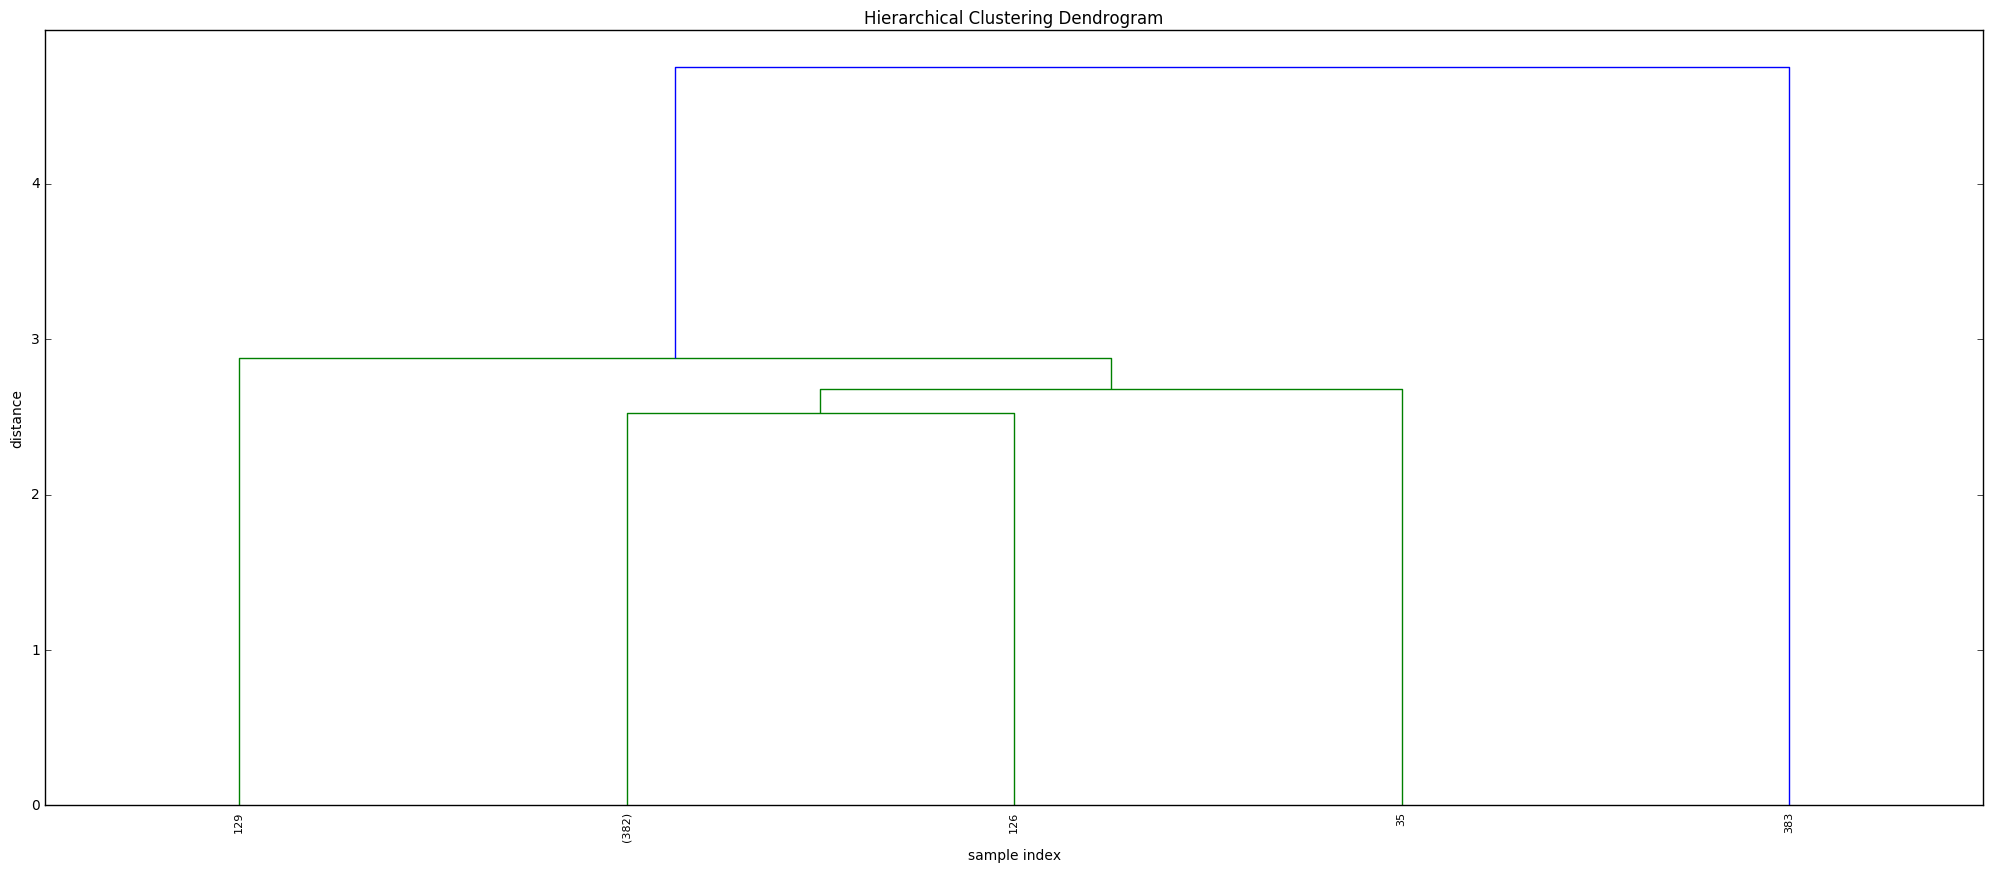

In [37]:
from scipy.cluster.hierarchy import dendrogram
from matplotlib import pyplot as plt
lm_arr2 = np.array(lm_arr)

# calculate full dendrogram
plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance')
dendrogram(
    lm_arr2,
    truncate_mode = 'lastp',
    p=5,
    #show_contracted = True,
    #color_threshold = 0.5,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=8.,  # font size for the x axis labels
)
plt.savefig('hac_new.png')

In [38]:
#dfs based search
#threshold value is the distance value above which no clusters are considered
# the first cluster that is found(non-singleton will be considered as one of the final clusters)
#a list reference will be provided that will collect all the final clusters
def dfs_search_4_final_clusters(root_cluster,threshold,final_cluster_list):
    #print(root_cluster)
    if(type(cluster_grouping_dict[root_cluster])==str):
        return
    else:
        stack = cluster_grouping_dict[root_cluster][:]
    #dfs_search_4_final_clusters(root_cluster=stack[0],threshold=threshold,final_cluster_list=final_cluster_list)
    while(len(stack)>0):
        if(type(stack)==str):
            return
        else:
            #considering each component cluster at a time
            cluster_cur = stack.pop()
            if(cluster_dist_df.loc[cluster_cur,'distance']<threshold):
                #crossing the threshold barrier
                final_cluster_list.append(cluster_cur)
                pass
            else:
                dfs_search_4_final_clusters(root_cluster=cluster_cur,threshold=threshold,final_cluster_list=final_cluster_list)

In [39]:
def dfs_search_n_mark_cluster_names(root_cluster,cluster_name):
    #print(root_cluster)
    if(type(cluster_grouping_dict[root_cluster])==str):
        #mark
        gene_id = int(cluster_grouping_dict[root_cluster][8:])+1
        #print(gene_id)
        idx_num= gene_2_cluster_mapping.index.get_loc(gene_id)
        gene_2_cluster_mapping.iloc[idx_num] = cluster_name
        return
    else:
        stack = cluster_grouping_dict[root_cluster][:]
    #dfs_search_4_final_clusters(root_cluster=stack[0],threshold=threshold,final_cluster_list=final_cluster_list)
    while(len(stack)>0):
        if(type(stack)==str):
            #mark
            gene_id = int(cluster_grouping_dict[root_cluster][8:])+1
            #print(gene_id)
            idx_num=gene_2_cluster_mapping.index.get_loc(gene_id)
            gene_2_cluster_mapping.iloc[idx_num] = cluster_name
            #print(gene_id)
            return
        else:
            #considering each component cluster at a time
            cluster_cur = stack.pop()
            dfs_search_n_mark_cluster_names(root_cluster=cluster_cur,cluster_name=cluster_name)

In [40]:
lm_df = pd.DataFrame(lm_arr)
lm_df_stats = lm_df.describe()
threshold = lm_df_stats.loc['75%',2]
threshold

1.2460774454262462

In [41]:
import copy
gcm = copy.deepcopy(gene_2_cluster_mapping)
idx_size = cluster_dist_df.index.size
idx_size-=1
final_cluster_list = list()
#threshold = 1.2
dfs_search_4_final_clusters(root_cluster=cluster_dist_df.index[idx_size],threshold=threshold,final_cluster_list=final_cluster_list)

In [42]:
for i in range(0,len(final_cluster_list)):
    dfs_search_n_mark_cluster_names(root_cluster=final_cluster_list[i],cluster_name=i)
#gene_2_cluster_mapping.loc[1,'cluster_name']="Cluster_770"

In [43]:
#print(gene_2_cluster_mapping)

#for i in range(0,len(final_cluster_list)):
#    dfs_search_n_mark_cluster_names(root_cluster=final_cluster_list[i],cluster_name=i)
gene_2_cluster_mapping[gene_2_cluster_mapping.cluster_name==cluster_dist_df.index[idx_size]]=-1



In [44]:
import itertools
def label_perm(x):
    idx = x-1
    return perm_list[idx]
def get_jc_label_permute(max_cluster_label_num,predicted_label,gnd_truth_vector):
    # returns final_label_pred,jc_value
    init_label = predicted_label[:]
    max_jc_value = 0
    final_label_pred = list()
    perm_list_cluster_labels = list(itertools.permutations(range(1,max_cluster_label_num+1)))
    iter_cnt = 0
    for tuple_labels in perm_list_cluster_labels:
        if(iter_cnt<25):
            iter_cnt+=1
            perm_cluster_label_list = list(tuple_labels)
            #pred = map(label_perm),init_label)
            pred = map((lambda x: perm_cluster_label_list[x-1]),init_label)
            js_score = jaccard_similarity_score(gnd_truth_vector,pred)
            if(js_score>max_jc_value):
                max_jc_value = js_score
                final_label_pred = pred[:]
        else:
            break
    return (max_jc_value,final_label_pred)

In [45]:
from sklearn.metrics import jaccard_similarity_score
gnd_truth_np = np.array(input_df.loc[:,'gnd_truth_cluster'],dtype=int)
#j_score,pred_label_map = get_jc_label_permute(max_cluster_label_num = len(final_cluster_list)+1,predicted_label=np.array(gene_2_cluster_mapping.cluster_name) ,gnd_truth_vector= gnd_truth_np)
js_score = jaccard_similarity_score(gnd_truth_np,gene_2_cluster_mapping.cluster_name.values.tolist())

In [46]:
js_score

0.098445595854922283

In [47]:
#gene_2_cluster_mapping.cluster_name.values.tolist()

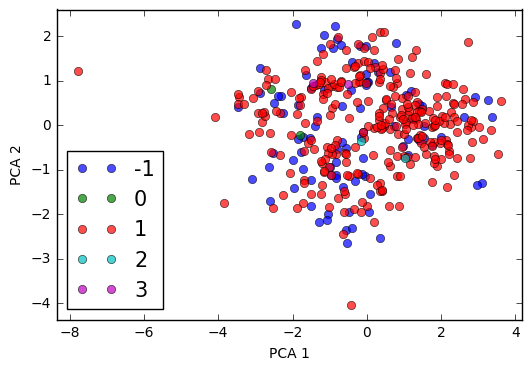

In [48]:
# Package to perform PCA
import sklearn.datasets
import sklearn.decomposition

# Perform the PCA again retaining only the top 2 components
sklearn_pca = sklearn.decomposition.PCA(n_components=2)
sklearn_pca.fit(np.array(gdf))

# Project the data into this 2D space and convert it back to a tidy dataframe
df_2D = pd.DataFrame(sklearn_pca.transform(np.array(gdf)),columns=['PCA1', 'PCA2'])
df_2D['clusters'] = gene_2_cluster_mapping['cluster_name']
df_2D.head()
for key, group in df_2D.groupby(['clusters']):
    plt.plot(group.PCA1, group.PCA2, 'o', alpha=0.7, label=key)

# Tidy up plot
plt.legend(loc=0, fontsize=15)
plt.margins(0.05)
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')